# Chapter 4 - Basics of Deep Learning

In [1]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import torch
import torchvision
import tqdm

# Convenience imports
from random import choice 
from numpy import array, dot, random
import sklearn.datasets
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm_notebook as tqdm
import copy
import itertools
import pandas as pd

np.random.seed(1)
%matplotlib inline  

## 2. MLP on Various Datasets
This example explores a two-layer neural network implemented in python and numpy.
Uncomment the dataset to be explored:
- Moons Dataset
- Circles Dataset
- XOR
- AND

Modified example from: 
https://github.com/dennybritz/nn-from-scratch

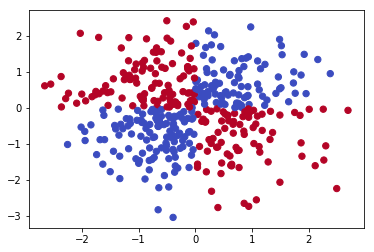

In [2]:
## Generate a dataset and plot it

## Moons Dataset ##
# X, y = sklearn.datasets.make_moons(200, noise=0.20)

## Circles dataset ##
# X, y = sklearn.datasets.make_circles(noise=0.2, factor=0.5, random_state=1)

## XOR with noise ##
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(400, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int) 

## AND with noise ##
# xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
#                      np.linspace(-3, 3, 50))
# rng = np.random.RandomState(0)
# X = rng.randn(400, 2)
# y = np.logical_and(X[:, 0] > 0, X[:, 1] > 0).astype(int) 


# Plot the dataset
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.coolwarm)

In [3]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [5]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [6]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [7]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Loss after iteration 0: 0.757321
Loss after iteration 1000: 0.430950
Loss after iteration 2000: 0.430943
Loss after iteration 3000: 0.430942
Loss after iteration 4000: 0.430941
Loss after iteration 5000: 0.430941
Loss after iteration 6000: 0.430940
Loss after iteration 7000: 0.430940
Loss after iteration 8000: 0.430940
Loss after iteration 9000: 0.430940
Loss after iteration 10000: 0.430939
Loss after iteration 11000: 0.430939
Loss after iteration 12000: 0.430939
Loss after iteration 13000: 0.430939
Loss after iteration 14000: 0.430939
Loss after iteration 15000: 0.430939
Loss after iteration 16000: 0.430939
Loss after iteration 17000: 0.430939
Loss after iteration 18000: 0.430939
Loss after iteration 19000: 0.430939


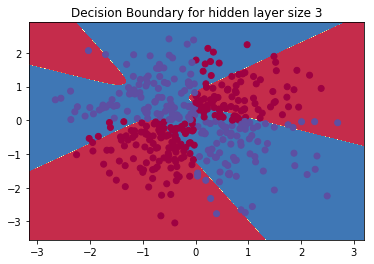

In [8]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

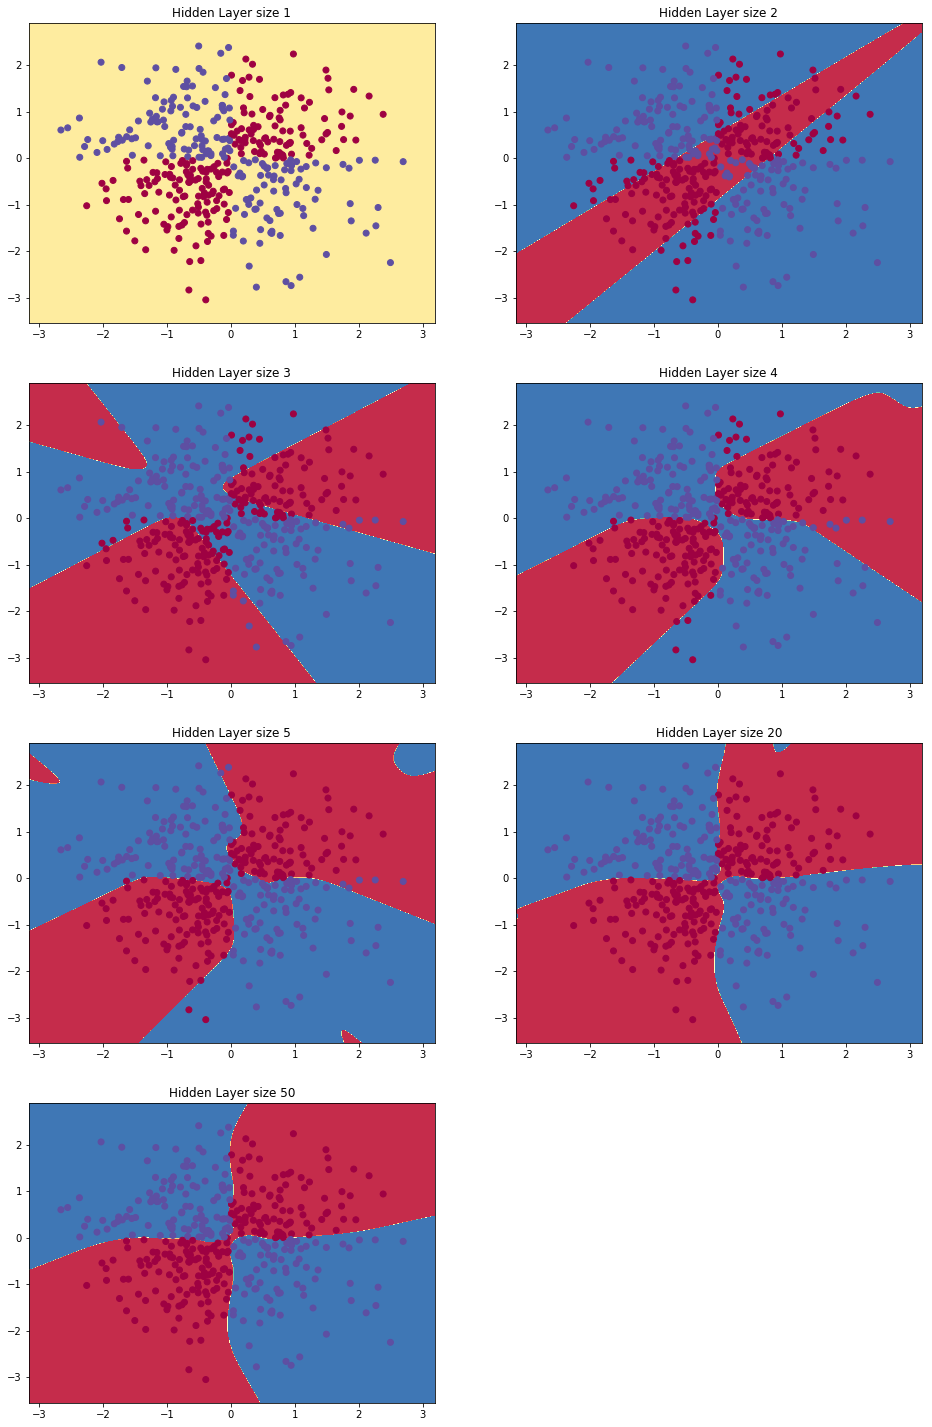

In [9]:
# Experiment with the hidden layer sizef
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

# 2. Spoken Digit Dataset
Spoken digits classification and generation.
Original dataset can be found here: https://github.com/Jakobovski/free-spoken-digit-dataset

In [10]:
import torch
import torchvision
from torch.utils import data
import torchaudio
from torch.utils.data.sampler import SubsetRandomSampler

import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import os
import re
import concurrent

import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import copy
import itertools
import pandas as pd
from tqdm import tnrange, tqdm_notebook
import librosa
import librosa.display

import IPython.display as ipd
from tqdm import tqdm_notebook as tqdm

use_cuda = torch.cuda.is_available()

### Download FSDD from Github

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

### Inspect the data downloaded

In [12]:
def plotRawWave(plotTitle, sampleRate, samples, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(samples)
    plt.title("Raw sound wave of " + plotTitle)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    plt.show()  # force display while in for loop
    return None

def computeLogSpectrogram(audio, sampleRate, windowSize=20, stepSize=10, epsilon=1e-10):
    nperseg  = int(round(windowSize * sampleRate / 1000))
    noverlap = int(round(stepSize   * sampleRate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sampleRate,
                                            window='ham',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + epsilon)

def plotSpectrogram(plotTitle, freqs, times, spectrogram, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               cmap="jet",   #  default was "viridis"  (perceptually uniform)
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(pad=0.01)
    plt.title('Spectrogram of ' + plotTitle)
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    fig.tight_layout()
    plt.show()  # force display while in for loop
    return None

def computeMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sampleRate, n_mels=nMels)
    
    return melSpectrum

def computeLogMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sampleRate, n_mels=128)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

def plotMelSpectrogram(plotTitle, sampleRate, melSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(melSpectrum, sr=sampleRate, x_axis='time', y_axis='mel', cmap="jet")
    plt.title('Mel frequency spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

def plotLogMelSpectrogram(plotTitle, sampleRate, logMelSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(logMelSpectrum, sr=sampleRate, x_axis='time', y_axis='mel', cmap="jet")
    plt.title('Mel log-frequency power spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

def computeMFCC(samples, sampleRate, nFFT=512, hopLength=256, nMFCC=40, norm=None):
    mfcc = librosa.feature.mfcc(y=samples.astype(np.float16), sr=sampleRate, 
                                n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC,
                                norm=norm)
    
    # Let's add on the first and second deltas 
    mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

def plotMFCC(plotTitle, sampleRate, mfcc, figWidth=14, figHeight=4):
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(mfcc, sr=sampleRate, x_axis='time',cmap="jet")
    plt.colorbar(pad=0.01)
    plt.title("Mel-frequency cepstral coefficients (MFCC): " + plotTitle)
    plt.tight_layout()
    plt.show()  # force display while in for loop
    return None

In [13]:
def showWavefile(filename):
    sampleRate, samples = wavfile.read(filename)  
    plotRawWave(filename, sampleRate, samples)
    
    melSpectrogram = computeMelSpectrogram(samples, sampleRate)
    
    logMelSpectrogram = computeLogMelSpectrogram(samples, sampleRate)
    plotLogMelSpectrogram(filename, sampleRate, logMelSpectrogram)
    
    return sampleRate, samples, logMelSpectrogram

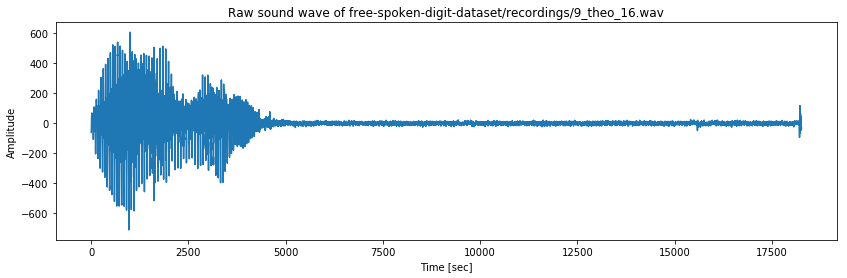

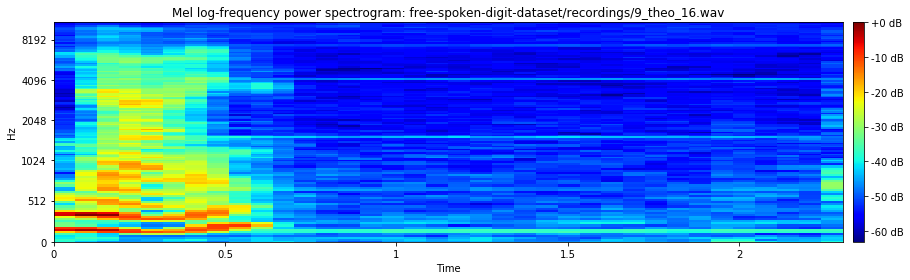

In [14]:
# Sample a file from the dataset
filename = 'free-spoken-digit-dataset/recordings/9_theo_16.wav'

ipd.display( ipd.Audio(filename) )
sampleRate, samples, logMelSpectrogram = showWavefile(filename)

## Increase the amount of data: Data Augmentation
The original dataset contains 1,500 examples (it has since grown to 2,000 at the time of this writing). We can create additional examples by augmenting the original files. Here we apply time stretching and pitch shifting to increase the number of examples. 

This has already been computed for convenience, so it is left commented out here. 

In [15]:
# Load Wav File Paths
original_wavfiles=[]

root='free-spoken-digit-dataset/recordings/'
for path, dirs, files in os.walk(root, topdown=True):
    for file in files:
        if file.endswith('.wav'):
            original_wavfiles.append(os.path.join(path, file))
print("Number of wavfiles: ", len(original_wavfiles))

Number of wavfiles:  2000


In [ ]:
augmented_dir = './data/wav/'
os.makedirs(augmented_dir, exist_ok=True)
default_sample_rate = 8000 # Reducing everything to 8kHz phone quality for efficiency

# Create Augmented examples
for file_path in tqdm(original_wavfiles):
    y, Fs = librosa.load(file_path) 
    for ts in [0.75,1,1.25]:
        for ps in [-1,0,+1]:
            y_new = librosa.effects.time_stretch(y, ts)
            y_new = librosa.effects.pitch_shift(y_new, Fs, n_steps=ps)
            basename = '_'.join([os.path.splitext(os.path.basename(file_path))[0],str(ts),str(ps)])+'.wav'
            output_file = os.path.join(augmented_dir, basename)
            librosa.output.write_wav(output_file, y_new, default_sample_rate)

In [ ]:
augmented_wavfiles=[]

root='./data/wav/'
for path, dirs, files in os.walk(root, topdown=True):
    for file in files:
        if file.endswith('.wav'):
            augmented_wavfiles.append(os.path.join(path, file))
print("Number of wavfiles: ", len(augmented_wavfiles))

Note: Loading audio and performing the FFT to convert it to the frequence spectrum requires repetative computation. We can save time on this conversion by computing it once and saving the features in numpy arrays, which will be much faster during loading. Furthermore, even doing this process once can take a significant amount of time, so we parallelize the process here. 

To simplify the network architecture, we fix the size of all examples in the dataset to 1.5s and save them if we need to inspect them. 

In [16]:
def trim_files(file_path, output_dir, max_length):
    samples, Fs = librosa.load(file_path) 
    short_samples = librosa.util.fix_length(samples, 12000)# int(max_length * Fs))

    basename = os.path.basename(file_path)
    output_file = os.path.join(output_dir, basename)
    librosa.output.write_wav(output_file, short_samples, Fs)

In [ ]:
executor = concurrent.futures.ProcessPoolExecutor(10)

trimmed_dir = './data/trimmed_wav/'
max_length = 1.5  # Maximum length in seconds
os.makedirs(trimmed_dir, exist_ok=True)
futures = [executor.submit(trim_files, file_path, trimmed_dir, max_length) for file_path in augmented_wavfiles]

concurrent.futures.wait(futures)

In [17]:
trimmed_wavfiles=[]

root='./data/trimmed_wav/'
for path, dirs, files in os.walk(root, topdown=True):
    for file in files:
        if file.endswith('.wav'):
            trimmed_wavfiles.append(os.path.join(path, file))
print("Number of wavfiles: ", len(trimmed_wavfiles))

Number of wavfiles:  18000


Save features as numpy arrays for faster loading.

In [18]:
def cache_spectrogram_features(file_path, output_dir):
    samples, Fs = librosa.load(file_path) 

    melSpectrum = librosa.feature.melspectrogram(samples.astype(np.float16), sr=Fs, n_mels=40)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    basename = os.path.splitext(os.path.basename(file_path))[0]+'.npy'
    output_file = os.path.join(output_dir, basename)
    np.save(output_file, logMelSpectrogram)

In [ ]:
executor = concurrent.futures.ProcessPoolExecutor(10)

feature_dir = './data/npy/'
os.makedirs(feature_dir, exist_ok=True)
futures = [executor.submit(cache_spectrogram_features, file_path, feature_dir) for file_path in trimmed_wavfiles]
concurrent.futures.wait(futures)

In [19]:
npyfiles=[]

root='data/npy/'
for path, dirs, files in os.walk(root, topdown=True):
    for file in files:
        if file.endswith('.npy'):
            npyfiles.append(os.path.join(path, file))
print("Number of npy files: ", len(npyfiles))

Number of npy files:  18000


### Creat audio dataset splits and data loaders

In [20]:
class AudioDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, filenames, labels, sr=8000):
        'Initialization'
        self.labels = labels
        self.filenames = filenames
        self.sr = sr

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.filenames)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        filename = self.filenames[index]
        # Load data and get label
        X = (torch.Tensor(np.load(filename))+80)/80  # 0 centered [-1,1]
        y = self.labels[int(os.path.basename(filename)[0])]  # First character in filename is class
        return X, y
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [21]:
audio_dataset = AudioDataset(npyfiles, list(range(10)))

In [22]:
validation_split = .1
testing_split = 0.1
shuffle_dataset = True
random_seed= 1

# Creating data indices for training and validation splits:
dataset_size = len(audio_dataset)
indices = list(range(dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

In [23]:
train_indices = indices[:int(-dataset_size*(validation_split+testing_split))]
val_indices = indices[int(-dataset_size*(validation_split+testing_split)):int(-dataset_size*testing_split)]
test_indices = indices[int(-dataset_size*testing_split):]

# # Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [24]:
print('Training examples: ' + str(len(train_sampler)))
print('Validation examples: ' + str(len(val_sampler)))
print('Testing examples: ' + str(len(test_sampler)))

Training examples: 14400
Validation examples: 1800
Testing examples: 1800


## Exploratory Data Analysis

In [92]:
# Create DataLoaders
dataloader_args = dict(batch_size=32, num_workers=8, pin_memory=False)
train_loader = torch.utils.data.DataLoader(audio_dataset, **dataloader_args, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(audio_dataset, **dataloader_args, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(audio_dataset, **dataloader_args, sampler=test_sampler)

#### 1. Let's look at a sample of our data to make sure that it looks reasonable. 

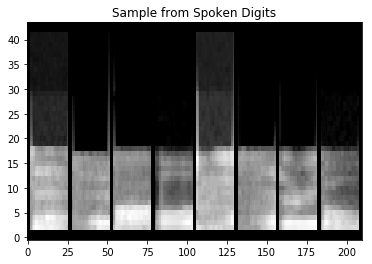

In [28]:
def imshow(img, title=''):
    img = img # unnormalize
    npimg = img.numpy()
    plt.title(title) if title is not None else plt.title(str(c).zfill(3))
    plt.imshow(np.transpose(npimg, (1,2,0)),interpolation='nearest', aspect='auto',origin='lower')

dataiter = iter(train_loader)
X, y = dataiter.next()
X = (X+40)/80
# X = X / torch.Tensor([40]).expand_as(X)
grid_img = torchvision.utils.make_grid(X.unsqueeze(1), normalize=True)
imshow(grid_img, title='Sample from Spoken Digits')

#### 2. Let's examine the balance between the classes.

In [31]:
def get_labels(loader):
    return np.asarray([label for batch in loader for label in batch[1]])

In [32]:
train_labels = get_labels(train_loader)
val_labels = get_labels(val_loader)
test_labels = get_labels(test_loader)

In [33]:
def show_hist(data, title):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), rwidth=0.5)
    plt.grid(True)
    plt.xticks(range(0, 10))
    plt.title(title)
    plt.ylabel("Number of examples")
    plt.xlabel("Example label")
    plt.show()

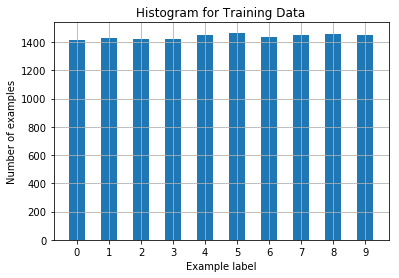

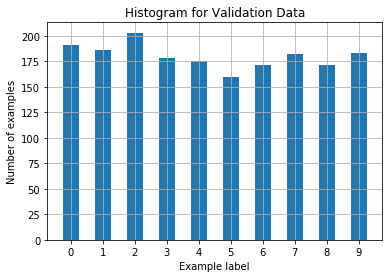

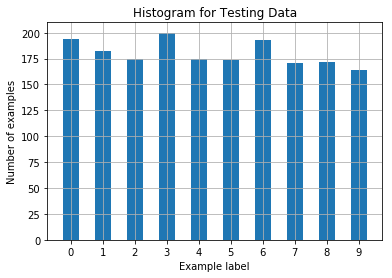

In [34]:
show_hist(train_labels, "Histogram for Training Data")
show_hist(val_labels, "Histogram for Validation Data")
show_hist(test_labels, "Histogram for Testing Data")

In [81]:
n_features = 960 # 40 logmel features * 24 time steps

## Training a Supervised Classifier

In [36]:
# Define model architecture in pytorch
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(self.input_size, 128)
        self.bc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 128)
        self.bc2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        x = x.view((-1, self.input_size))
        h = self.fc1(x)
        h = self.bc1(h)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc3(h)
        out = torch.log_softmax(h,dim=1)
        return out



In [38]:
model = Model(n_features)
# Track metrics when training
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epoch = 40
train_losses = []
val_losses = []
best_val = np.inf
best_model = copy.deepcopy(model)
accuracies = []

device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)

# Train the model
for epoch in range(n_epoch):
    print('Epoch: ' + str(epoch + 1)) #Index at 0
    # Training loop
    model.train()
    correct = 0
    train_loss = 0
    with tqdm_notebook(enumerate(train_loader), total=len(train_loader)) as pbar:
        for batch_idx, (data, target) in pbar:
            # Get Samples
            data, target = data.to(device), target.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward Propagation 
            y_pred = model(data) 

            # Error Computation
            loss = F.cross_entropy(y_pred, target)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Track training loss
            train_loss += loss.data.sum()
            
            #Added to look at training accuracy
            pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            pbar.set_description("Current loss %.4f" % (train_loss/(len(target)*(1+batch_idx))))
    train_losses.append(train_loss/len(train_loader.sampler.indices))
    print('Training set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_losses[-1], correct, len(train_loader.sampler.indices),
        100. * correct / len(train_loader.sampler.indices)))
    
    # Validation Loop
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.sampler.indices)
    val_losses.append(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        best_model = copy.deepcopy(model)
    accuracy = 100. * correct / len(val_loader.sampler.indices)
    accuracies.append(accuracy)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_indices), accuracy))

Epoch: 1



Training set: Average loss: 0.0273, Accuracy: 10093/14400 (70%)


Validation set: Average loss: 0.5580, Accuracy: 1416/1800 (79%)

Epoch: 2



Training set: Average loss: 0.0171, Accuracy: 11765/14400 (82%)


Validation set: Average loss: 0.2950, Accuracy: 1631/1800 (91%)

Epoch: 3



Training set: Average loss: 0.0147, Accuracy: 12132/14400 (84%)


Validation set: Average loss: 0.2452, Accuracy: 1650/1800 (92%)

Epoch: 4



Training set: Average loss: 0.0136, Accuracy: 12318/14400 (86%)


Validation set: Average loss: 0.2549, Accuracy: 1634/1800 (91%)

Epoch: 5



Training set: Average loss: 0.0123, Accuracy: 12520/14400 (87%)


Validation set: Average loss: 0.1769, Accuracy: 1700/1800 (94%)

Epoch: 6



Training set: Average loss: 0.0119, Accuracy: 12571/14400 (87%)


Validation set: Average loss: 0.1422, Accuracy: 1723/1800 (96%)

Epoch: 7



Training set: Average loss: 0.0112, Accuracy: 12697/14400 (88%)


Validation set: Average loss: 0.1778, Accuracy: 1693/1800 (94%)

Epoch: 8



Training set: Average loss: 0.0109, Accuracy: 12767/14400 (89%)


Validation set: Average loss: 0.1658, Accuracy: 1711/1800 (95%)

Epoch: 9



Training set: Average loss: 0.0108, Accuracy: 12772/14400 (89%)


Validation set: Average loss: 0.1677, Accuracy: 1716/1800 (95%)

Epoch: 10



Training set: Average loss: 0.0108, Accuracy: 12713/14400 (88%)


Validation set: Average loss: 0.1603, Accuracy: 1711/1800 (95%)

Epoch: 11



Training set: Average loss: 0.0103, Accuracy: 12832/14400 (89%)


Validation set: Average loss: 0.1428, Accuracy: 1731/1800 (96%)

Epoch: 12



Training set: Average loss: 0.0098, Accuracy: 12926/14400 (90%)


Validation set: Average loss: 0.1202, Accuracy: 1734/1800 (96%)

Epoch: 13



Training set: Average loss: 0.0099, Accuracy: 12946/14400 (90%)


Validation set: Average loss: 0.1089, Accuracy: 1743/1800 (97%)

Epoch: 14



Training set: Average loss: 0.0095, Accuracy: 13037/14400 (91%)


Validation set: Average loss: 0.1499, Accuracy: 1718/1800 (95%)

Epoch: 15



Training set: Average loss: 0.0094, Accuracy: 12955/14400 (90%)


Validation set: Average loss: 0.1171, Accuracy: 1744/1800 (97%)

Epoch: 16



Training set: Average loss: 0.0093, Accuracy: 12959/14400 (90%)


Validation set: Average loss: 0.0921, Accuracy: 1760/1800 (98%)

Epoch: 17



Training set: Average loss: 0.0087, Accuracy: 13092/14400 (91%)


Validation set: Average loss: 0.1318, Accuracy: 1720/1800 (96%)

Epoch: 18



Training set: Average loss: 0.0088, Accuracy: 13070/14400 (91%)


Validation set: Average loss: 0.0912, Accuracy: 1756/1800 (98%)

Epoch: 19



Training set: Average loss: 0.0088, Accuracy: 13069/14400 (91%)


Validation set: Average loss: 0.0791, Accuracy: 1749/1800 (97%)

Epoch: 20



Training set: Average loss: 0.0087, Accuracy: 13095/14400 (91%)


Validation set: Average loss: 0.0965, Accuracy: 1741/1800 (97%)

Epoch: 21



Training set: Average loss: 0.0088, Accuracy: 13102/14400 (91%)


Validation set: Average loss: 0.1111, Accuracy: 1744/1800 (97%)

Epoch: 22



Training set: Average loss: 0.0085, Accuracy: 13136/14400 (91%)


Validation set: Average loss: 0.1185, Accuracy: 1729/1800 (96%)

Epoch: 23



Training set: Average loss: 0.0082, Accuracy: 13208/14400 (92%)


Validation set: Average loss: 0.0768, Accuracy: 1757/1800 (98%)

Epoch: 24



Training set: Average loss: 0.0081, Accuracy: 13168/14400 (91%)


Validation set: Average loss: 0.0760, Accuracy: 1761/1800 (98%)

Epoch: 25



Training set: Average loss: 0.0081, Accuracy: 13144/14400 (91%)


Validation set: Average loss: 0.0789, Accuracy: 1759/1800 (98%)

Epoch: 26



Training set: Average loss: 0.0085, Accuracy: 13151/14400 (91%)


Validation set: Average loss: 0.0823, Accuracy: 1756/1800 (98%)

Epoch: 27



Training set: Average loss: 0.0080, Accuracy: 13216/14400 (92%)


Validation set: Average loss: 0.0677, Accuracy: 1767/1800 (98%)

Epoch: 28



Training set: Average loss: 0.0080, Accuracy: 13236/14400 (92%)


Validation set: Average loss: 0.0754, Accuracy: 1764/1800 (98%)

Epoch: 29



Training set: Average loss: 0.0073, Accuracy: 13269/14400 (92%)


Validation set: Average loss: 0.0699, Accuracy: 1757/1800 (98%)

Epoch: 30



Training set: Average loss: 0.0074, Accuracy: 13300/14400 (92%)


Validation set: Average loss: 0.0825, Accuracy: 1757/1800 (98%)

Epoch: 31



Training set: Average loss: 0.0081, Accuracy: 13144/14400 (91%)


Validation set: Average loss: 0.0830, Accuracy: 1759/1800 (98%)

Epoch: 32



Training set: Average loss: 0.0077, Accuracy: 13209/14400 (92%)


Validation set: Average loss: 0.0756, Accuracy: 1755/1800 (98%)

Epoch: 33



Training set: Average loss: 0.0075, Accuracy: 13268/14400 (92%)


Validation set: Average loss: 0.0710, Accuracy: 1748/1800 (97%)

Epoch: 34



Training set: Average loss: 0.0076, Accuracy: 13250/14400 (92%)


Validation set: Average loss: 0.0671, Accuracy: 1767/1800 (98%)

Epoch: 35



Training set: Average loss: 0.0075, Accuracy: 13281/14400 (92%)


Validation set: Average loss: 0.0792, Accuracy: 1755/1800 (98%)

Epoch: 36



Training set: Average loss: 0.0076, Accuracy: 13287/14400 (92%)


Validation set: Average loss: 0.0962, Accuracy: 1749/1800 (97%)

Epoch: 37



Training set: Average loss: 0.0072, Accuracy: 13327/14400 (93%)


Validation set: Average loss: 0.0646, Accuracy: 1759/1800 (98%)

Epoch: 38



Training set: Average loss: 0.0073, Accuracy: 13309/14400 (92%)


Validation set: Average loss: 0.0730, Accuracy: 1756/1800 (98%)

Epoch: 39



Training set: Average loss: 0.0073, Accuracy: 13293/14400 (92%)


Validation set: Average loss: 0.0728, Accuracy: 1764/1800 (98%)

Epoch: 40



Training set: Average loss: 0.0073, Accuracy: 13318/14400 (92%)


Validation set: Average loss: 0.0766, Accuracy: 1761/1800 (98%)



In [39]:
def plot_learning_curves(train_losses, val_losses, accuracies):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.set_ylabel("Loss")
    ax1.plot(range(len(train_losses)), train_losses, label='Training Loss')
    ax1.plot(range(len(train_losses)), val_losses, label='Validation Loss')
    ax2.plot(range(len(accuracies)), accuracies, label='Validation Accuracy', color='g')
    ax2.set_ylabel('Accuracy')
    
    plt.title("Training/Validation Curves")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    
    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles+handles2, labels+labels2, bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.show()

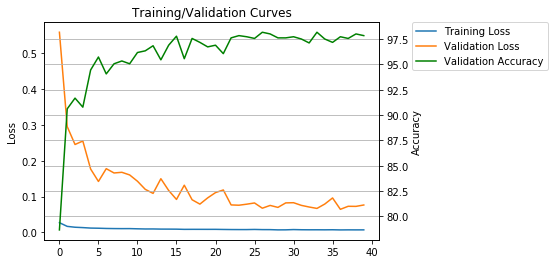

In [40]:
plot_learning_curves(train_losses, val_losses, accuracies)

In [41]:
# Test Set
model.eval()
val_loss = 0
correct = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

val_loss /= len(val_loader.sampler.indices)
# val_losses.append(val_loss)
if val_loss < best_val:
    best_val = val_loss
    best_model = copy.deepcopy(model)
accuracy = 100. * correct / len(val_loader.sampler.indices)
# accuracies.append(accuracy)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(val_indices), accuracy))


Test set: Average loss: 0.0791, Accuracy: 1753/1800 (97%)



## Restricted Boltzmann Machine
Train an RBM to generate examples from the MNIST dataset.

Modificaiton of the example shown: https://github.com/odie2630463/Restricted-Boltzmann-Machines-in-pytorch/blob/master/RBM.ipynb

In [86]:
def show(file_name,img):
    npimg = np.transpose(img.numpy(),(2,1,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
#     plt.imsave(f,npimg)

In [87]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=256,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2).to(device)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - torch.rand(p.size()).to(device)))
    
    def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v.to(device),self.W.to(device),self.h_bias.to(device)))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h.to(device),self.W.t().to(device),self.v_bias.to(device)))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [88]:
rbm = RBM(n_vis=n_features, n_hin=128, k=1)
device = torch.device("cuda" if use_cuda else "cpu")
rbm.to(device)

train_op = optim.Adam(rbm.parameters(), 0.001)

num_epochs = 20

for epoch in range(num_epochs):
    loss_ = []
    total_loss = 0
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,n_features)).to(device)
        sample_data = torch.bernoulli(data)
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
#         total_loss += loss
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch + 1, num_epochs, torch.mean(loss)))

epoch [1/20], loss: -3.8148
epoch [2/20], loss: -4.3237
epoch [3/20], loss: -2.1106
epoch [4/20], loss: 6.8589
epoch [5/20], loss: 1.1587
epoch [6/20], loss: 1.2027
epoch [7/20], loss: -0.2389
epoch [8/20], loss: -3.6037
epoch [9/20], loss: -5.6410
epoch [10/20], loss: -4.6792
epoch [11/20], loss: -1.6143
epoch [12/20], loss: -1.7649
epoch [13/20], loss: -5.0033
epoch [14/20], loss: 1.1906
epoch [15/20], loss: -1.7115
epoch [16/20], loss: -0.6280
epoch [17/20], loss: -2.3931
epoch [18/20], loss: -3.6292
epoch [19/20], loss: 4.7019
epoch [20/20], loss: -6.6270


Show real and generated features that have been learned by the RBM.

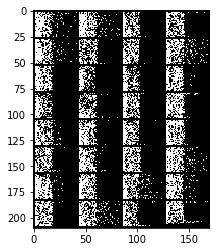

In [82]:
show("real",make_grid(v.view(32, 1, 40, 24).cpu()))

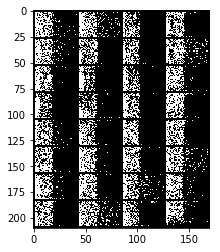

In [83]:
show("generate",make_grid(v1.view(32, 1, 40, 24).cpu().data))

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [94]:
# Extract features from our training set
batch_size = train_loader.batch_size
output_size = 128
input_size = n_features

train_features = np.zeros((len(train_loader)*batch_size, output_size))
train_labels = np.zeros(len(train_loader)*batch_size)
test_features = np.zeros((len(test_loader)*batch_size, output_size))
test_labels = np.zeros(len(test_loader)*batch_size)

for i, (batch,labels) in enumerate(train_loader):
    batch = Variable(batch.view(-1,input_size))  # flatten input data

#     train_features[i*batch_size:i*batch_size+len(batch)] = rbm_2.v_to_h(rbm_1.v_to_h(batch)[0])[0].cpu().data.numpy()
    train_features[i*batch_size:i*batch_size+len(batch)] = rbm.v_to_h(batch)[0].cpu().data.numpy()
#     train_features[i*batch_size:i*batch_size+len(batch)] = model(batch)[0].cpu().data.numpy()
    train_labels[i*batch_size:(i+1)*batch_size] = labels.numpy()

for i, (batch, labels) in enumerate(test_loader):
    batch = Variable(batch.view(-1,input_size))  # flatten input data

#     test_features[i*batch_size:i*batch_size+len(batch)] = rbm_2.v_to_h(rbm_1.v_to_h(batch)[0])[0].cpu().data.numpy()
    test_features[i*batch_size:i*batch_size+len(batch)] = rbm.v_to_h(batch)[0].cpu().data.numpy()
#     test_features[i*batch_size:i*batch_size+len(batch)] = model(batch)[0].cpu().data.numpy()
    test_labels[i*batch_size:i*batch_size+len(batch)] = labels.numpy()

In [96]:
# Train a Logistic Regression classifier on the extracted features
clf = LogisticRegression()
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)

print('Result: %d/%d' % (sum(predictions == test_labels), test_labels.shape[0]))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Result: 1543/1824


In [100]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(predictions, test_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[179   0   6   5   0   0   5   0   6   1]
 [  0 150   0   0   3   8   0   0   0   2]
 [  0   0 145  18   0   0  10   4   0   0]
 [  3   2  10 153   0   0   8   2   0   0]
 [  0   8   0   0 166   0   0   0   1   0]
 [  0  11   0   2   2 165   1   8   0   3]
 [  3   1   5   5   3   0 134  16   6   0]
 [  6   4   7   7   1   0  16 137   1   1]
 [  0   0   2  10   0   0  19   2 158   1]
 [ 27   6   0   0   0   1   0   2   0 156]]
Normalized confusion matrix
[[ 0.89  0.    0.03  0.02  0.    0.    0.02  0.    0.03  0.  ]
 [ 0.    0.92  0.    0.    0.02  0.05  0.    0.    0.    0.01]
 [ 0.    0.    0.82  0.1   0.    0.    0.06  0.02  0.    0.  ]
 [ 0.02  0.01  0.06  0.86  0.    0.    0.04  0.01  0.    0.  ]
 [ 0.    0.05  0.    0.    0.95  0.    0.    0.    0.01  0.  ]
 [ 0.    0.06  0.    0.01  0.01  0.86  0.01  0.04  0.    0.02]
 [ 0.02  0.01  0.03  0.03  0.02  0.    0.77  0.09  0.03  0.  ]
 [ 0.03  0.02  0.04  0.04  0.01  0.    0.09  0.76  0.01  0.0

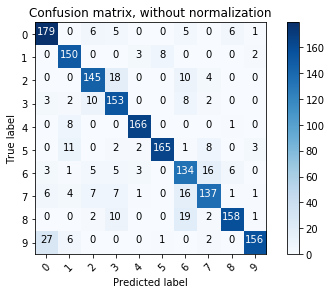

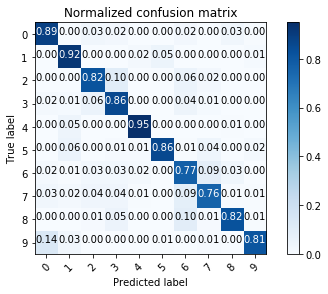

In [101]:
# Display confusion matrix
plt.figure()
class_names = [0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#  Autoencoder
Train an autoencoder to learn a compressed representation of the spoken digits.

Modification of example shown: https://github.com/SherlockLiao/pytorch-beginner/tree/master/08-AutoEncoder

In [55]:
# PyTorch model definition 
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.input_size = input_size
        
        self.e_fc1 = nn.Linear(self.input_size, 512)        
        self.e_fc2 = nn.Linear(512, 128)
        self.e_fc3 = nn.Linear(128, 64)
        self.e_fc4 = nn.Linear(64,64)
        
        self.d_fc1 = nn.Linear(64, 64)
        self.d_fc2 = nn.Linear(64, 128)
        self.d_fc3 = nn.Linear(128, 512)
        self.d_fc4 = nn.Linear(512, self.input_size)
    
    def forward(self, x):
        # Encoder
        h = F.relu(self.e_fc1(x))
        h = F.relu(self.e_fc2(h))
        h = F.relu(self.e_fc3(h))
        h = self.e_fc4(h)
        
        # Decoder
        h = F.relu(self.d_fc1(h))
        h = F.relu(self.d_fc2(h))
        h = F.relu(self.d_fc3(h))
        h = self.d_fc4(h)
        out = torch.tanh(h)

        return out

In [58]:
# Convert tensor to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 40, 24)
    return x

epoch [1/20], loss:0.0063
epoch [2/20], loss:0.0052
epoch [3/20], loss:0.0042
epoch [4/20], loss:0.0029
epoch [5/20], loss:0.0030
epoch [6/20], loss:0.0034
epoch [7/20], loss:0.0027
epoch [8/20], loss:0.0029
epoch [9/20], loss:0.0029
epoch [10/20], loss:0.0028
epoch [11/20], loss:0.0036
epoch [12/20], loss:0.0031
epoch [13/20], loss:0.0026
epoch [14/20], loss:0.0029
epoch [15/20], loss:0.0027
epoch [16/20], loss:0.0030
epoch [17/20], loss:0.0026
epoch [18/20], loss:0.0025
epoch [19/20], loss:0.0025
epoch [20/20], loss:0.0024


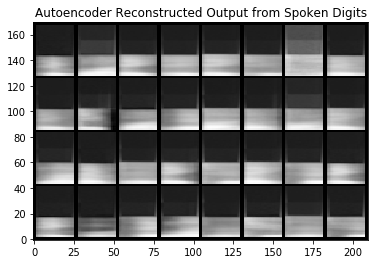

In [59]:
num_epochs = 20
batch_size = 128
learning_rate = 0.001

model = autoencoder(n_features)
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)
save_dir = './autoencoder_imgs/'
os.makedirs(save_dir, exist_ok=True)


for epoch in range(num_epochs):
    for data, target in train_loader:
        # Get samples
        input = data.view(-1,n_features).to(device)  # We will reuse the formatted input as our target
        
        # Forward Propagation
        output = model(input)

        # Error Computation
        loss = F.mse_loss(output, input)

        # Clear gradients
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Parameter Update
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        grid_img = torchvision.utils.make_grid(pic, normalize=True)
        imshow(grid_img, title='Autoencoder Reconstructed Output from Spoken Digits')
        save_image(pic, os.path.join(save_dir, 'image_{}.png'.format(epoch)))